In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import collections 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')

import torch
from torch import nn
from torch.utils import data
from torchvision.transforms import Compose, ToTensor

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
factors = open('data/factors.txt', 'r').readlines()

In [5]:
dfc = []
for factor in factors:
    df = pd.read_excel(f'Data/{factor}', index_col=0)
    df = df.reset_index().rename(columns={'index': 'symbol'})
    #df['symbol'] = df['symbol'].apply(lambda x: x[1:])
    df = df.rename(columns={'HTH domain amino acid sequences':'HTH_seq', 
                       'Binding sites':'sites', 'site':'sites',
                       'Aligned binding motifs':'aligned_motifs',
                       'aligned sites':'aligned_motifs',
                       'locus_tag TF':'TF_genes', 'regulated gene':'target_gene',
                       'Regulated operons':'target_operons',
                       'TF genes':'TF_genes'})
    if not 'symbol' in df.columns: df['symbol'] = '-'
    if not 'target_operons' in df.columns: df['target_operons'] = '-'
    df = df[['symbol','HTH_seq','aligned_motifs','sites','TF_genes', 'target_operons']]
    df['Factor'] = factor.split('.')[0]
    dfc.append(df)
dfc = pd.concat(dfc)
dfc.reset_index().rename(columns={'index': 'internal_index'})
dfc['symbol'] = dfc['symbol'].apply(lambda x: x.replace('>', ''))
dfc.to_csv('Data_prepared.csv', index=False)

In [6]:
df1 = df = pd.read_excel(f'Data/{factors[1]}', index_col=0)

In [214]:
df = pd.read_csv('Data_prepared.csv')

In [215]:
df = df.dropna(axis=0, subset=['HTH_seq','sites'])
df.to_csv('Data_prepared_filtered.csv')

In [9]:
print('Occuring lengths of HTH domain sequence:', set(df['HTH_seq'].dropna().apply(len)))
print('Occuring lengths of DNA sites:', set(df['sites'].dropna().apply(len)))
print('Occuring lengths of DNA site alignments:', set(df['aligned_motifs'].dropna().apply(len)))

In [266]:
df = df.loc[df[['HTH_seq','aligned_motifs', 'Factor']].drop_duplicates().index]

### Train/Test/Val split

In [267]:
test = df[df['Factor']=='YtrA']
train = df[df['Factor']!='YtrA']
test2 = train.sample(int(len(train)*0.12))
train = train.drop(test2.index)
test = test.append(test2)

In [269]:
strats = dict(zip(train['HTH_seq'].value_counts()[:30].index, np.arange(1,31)))
train['cv_strata'] = train['HTH_seq'].apply(lambda x: strats[x] if x in strats else 0)

In [270]:
from sklearn.model_selection import StratifiedKFold
stratKF = StratifiedKFold(n_splits=5, shuffle=True)
splits = stratKF.get_n_splits(X=train, y=train['cv_strata'].values)

In [271]:
test.to_csv('./Data/small_Test_particle.csv')

In [272]:
i = 0
for train_index, test_index in stratKF.split(X=train, y=train['cv_strata'].values):
    train_particle, val_particle = train.iloc[train_index], train.iloc[test_index]
    train_particle.to_csv(f'./Data/small_Train_particle_{i}.csv')
    val_particle.to_csv(f'./Data/small_Val_particel_{i}.csv')
    i += 1

In [98]:
NucEnc = {'A':'0','T':'1','C':'2','G':'3','-':'4','X':'5'}
AmEnc = set(''.join(df['HTH_seq'].dropna().values)).union('Z')
AmEnc = {k:str(i) for i,k in enumerate(sorted(list(AmEnc)))}

In [109]:
OneHotDNA = lambda x: OneHotEncode(x, NucEnc)
OneHotProtein = lambda x: OneHotEncode(x, AmEnc)

dat_train = PdDataset(df, positive_rate=0.2, preprocess_y=Compose([Upper, Pad(80), OneHotDNA]),
                      preprocess_x=Compose([Pad(80, pad_symbol='Z'), OneHotProtein]),
                transforms=Compose([to_tensor, scatter_torch(len(AmEnc)), crop_out_padding, to_float]),
                 transforms_x2=Compose([to_tensor, scatter_torch(len(NucEnc)), crop_out_padding, to_float]),      
                transforms_y=Compose([to_tensor]))

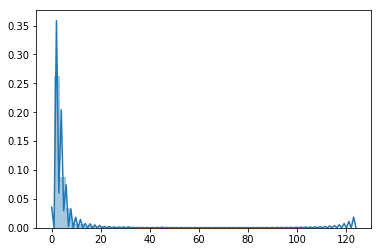

In [171]:
sns.distplot(df['HTH_seq'].value_counts().values)